 # 04_EDA.ipynb — Proyecto Aurora



 Análisis exploratorio centrado en:

 - Comparar Canal A vs Canal B (usuarios, ingresos, estabilidad)

 - Evolución temporal (DAU, ingresos)

 - Patrones por día de la semana

 - Correlaciones entre métricas clave

 - Distribución geográfica de ventas (Steam)

 - Distribución del gasto in-game (PlayFab) y "whales"

In [64]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

sns.set_theme(style="whitegrid")

BASE_PATH = ".."
FINAL_PATH = os.path.join(BASE_PATH, "data", "final")
CLEAN_PATH = os.path.join(BASE_PATH, "data", "clean")
RAW_PATH = os.path.join(BASE_PATH, "data", "raw")
EDA_PLOTS = os.path.join(BASE_PATH, "EDA", "plots")

os.makedirs(EDA_PLOTS, exist_ok=True)

def guardar_fig(nombre):
    ruta = os.path.join(EDA_PLOTS, f"{nombre}.png")
    plt.savefig(ruta, dpi=150, bbox_inches="tight")
    print(f"📁 Guardado: {ruta}")



 ## 1. Carga de datos

In [65]:
# FACT DIARIO CONSOLIDADO
fact = pd.read_csv(os.path.join(FINAL_PATH, "fact_diario.csv"))
fact["Fecha"] = pd.to_datetime(fact["Fecha"], errors="coerce")

# Steam ventas in-game (para países/regiones)
steam_sales = pd.read_csv(os.path.join(RAW_PATH, "SteamInGameSales.csv"))
steam_sales["Date"] = pd.to_datetime(steam_sales["Date"], errors="coerce")

# PlayFab limpio (opcional)
playfab_path = os.path.join(CLEAN_PATH, "playfab_clean.csv")
playfab = None
if os.path.exists(playfab_path):
    playfab = pd.read_csv(playfab_path)
    if "Fecha" in playfab.columns:
        playfab["Fecha"] = pd.to_datetime(playfab["Fecha"], errors="coerce")

print("✅ fact_diario:", fact.shape)
print(
    fact[["Fecha", "Plataforma"]]
    .groupby("Plataforma")
    .agg(
        min_fecha=("Fecha", "min"),
        max_fecha=("Fecha", "max"),
        dias=("Fecha", "nunique"),
    )
)

print("\nValores nulos por columna en FACT:")
print(fact.isna().sum())



✅ fact_diario: (2596, 19)
            min_fecha  max_fecha  dias
Plataforma                            
Canal A    2022-06-01 2025-10-31  1249
Canal B    2022-06-01 2025-10-31  1249

Valores nulos por columna en FACT:
Fecha                            0
Año                              0
Trimestre                        0
Mes                              0
Mes_Nombre                       0
DiaSemana                        0
DiaSemana_Nombre                 0
Plataforma                       0
Juego                            0
DAU                              0
Descargas                        0
Ingresos_USD                     0
Ingresos_Brutos_USD           1249
Unidades_Vendidas             1249
Usuarios_Concurrentes_Pico    1249
Oro_Gastado_USD               1347
ARPDAU                        1347
ARPU                          1347
ARPPU                         1347
dtype: int64


 ## 2. Feature engineering básico

In [66]:
# Por seguridad, si no existen las columnas de rolling, las creamos
fact = fact.sort_values("Fecha")

if "DAU_roll7" not in fact.columns:
    fact["DAU_roll7"] = fact.groupby("Plataforma")["DAU"].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )

if "Ingresos_roll7" not in fact.columns:
    fact["Ingresos_roll7"] = fact.groupby("Plataforma")["Ingresos_USD"].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )

if "AñoMes" not in fact.columns:
    fact["AñoMes"] = fact["Fecha"].dt.to_period("M").astype(str)

# Split por plataforma
fact_A = fact[fact["Plataforma"] == "Canal A"].copy()
fact_B = fact[fact["Plataforma"] == "Canal B"].copy()

print("\nPlataformas en FACT:", fact["Plataforma"].unique())
print("Canal A:", fact_A.shape, "| Canal B:", fact_B.shape)




Plataformas en FACT: ['Canal A' 'Canal B']
Canal A: (1347, 22) | Canal B: (1249, 22)


 ## 3. KPIs básicos por plataforma

In [67]:
kpi = (
    fact.groupby("Plataforma")
    .agg(
        DAU_medio=("DAU", "mean"),
        DAU_total=("DAU", "sum"),
        Descargas_total=("Descargas", "sum"),
        Ingresos_total=("Ingresos_USD", "sum"),
        Dias=("Fecha", "nunique"),
    )
)

kpi["Ingresos_dia_medio"] = kpi["Ingresos_total"] / kpi["Dias"]
print(kpi.round(2))



            DAU_medio  DAU_total  Descargas_total  Ingresos_total  Dias  \
Plataforma                                                                
Canal A       1496.99    2016447          74508.0      1256988.89  1249   
Canal B       3241.53    4048675         213439.0       941352.55  1249   

            Ingresos_dia_medio  
Plataforma                      
Canal A                1006.40  
Canal B                 753.68  


 ## 4. DAU — estabilidad y patrones

📁 Guardado: ..\EDA\plots\dau_rolling7.png


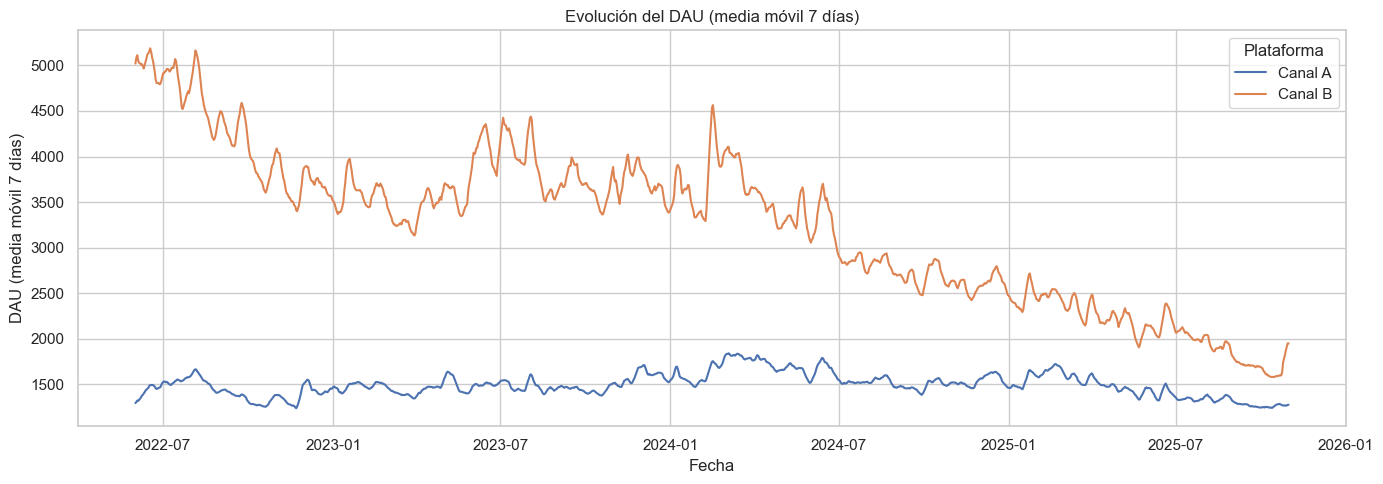

In [68]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=fact, x="Fecha", y="DAU_roll7", hue="Plataforma")
plt.title("Evolución del DAU (media móvil 7 días)")
plt.xlabel("Fecha")
plt.ylabel("DAU (media móvil 7 días)")
plt.tight_layout()
guardar_fig("dau_rolling7")
plt.show()


📁 Guardado: ..\EDA\plots\dau_estabilidad_boxplot.png


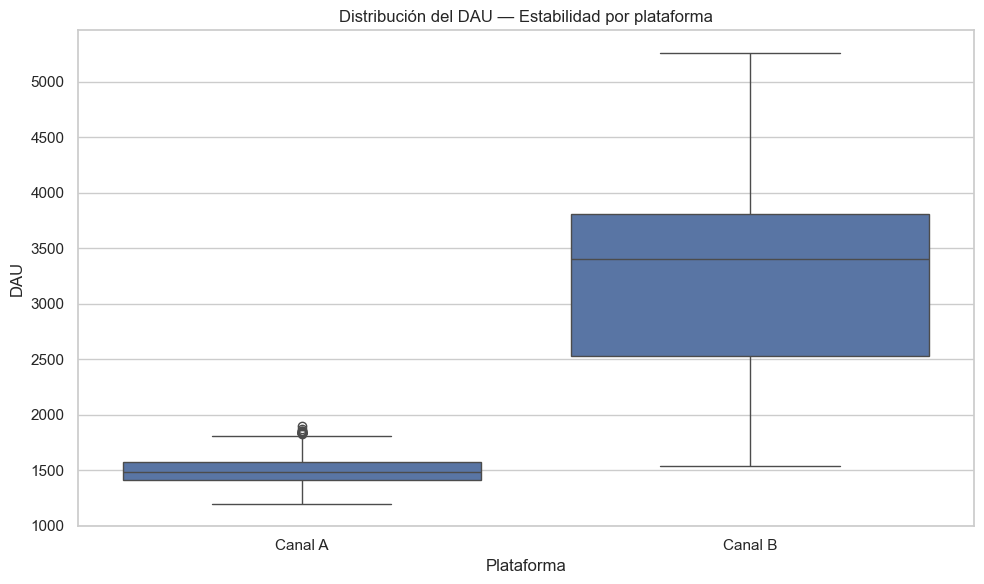

In [69]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=fact, x="Plataforma", y="DAU")
plt.title("Distribución del DAU — Estabilidad por plataforma")
plt.xlabel("Plataforma")
plt.ylabel("DAU")
plt.tight_layout()
guardar_fig("dau_estabilidad_boxplot")
plt.show()


C:\Users\cubea\AppData\Local\Temp\ipykernel_37236\706823868.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


📁 Guardado: ..\EDA\plots\dau_por_dia_semana.png


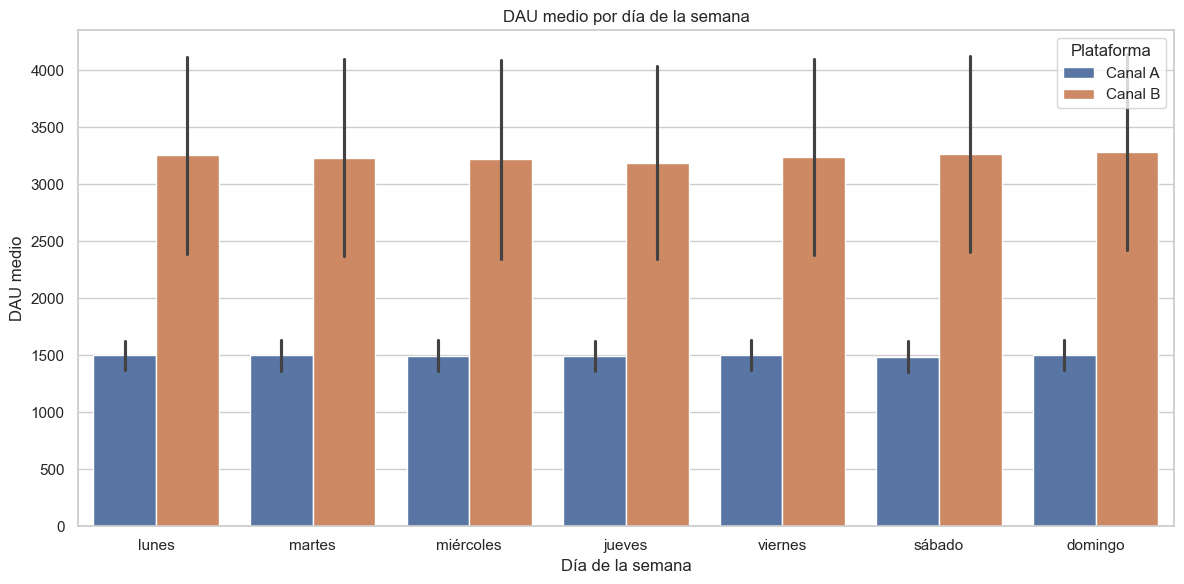

In [70]:
order_dias = ["lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=fact,
    x="DiaSemana_Nombre",
    y="DAU",
    hue="Plataforma",
    order=order_dias,
    ci="sd",
)
plt.title("DAU medio por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("DAU medio")
plt.tight_layout()
guardar_fig("dau_por_dia_semana")
plt.show()



 ## 5. Ingresos — evolución y estacionalidad

📁 Guardado: ..\EDA\plots\ingresos_diarios_rolling7.png


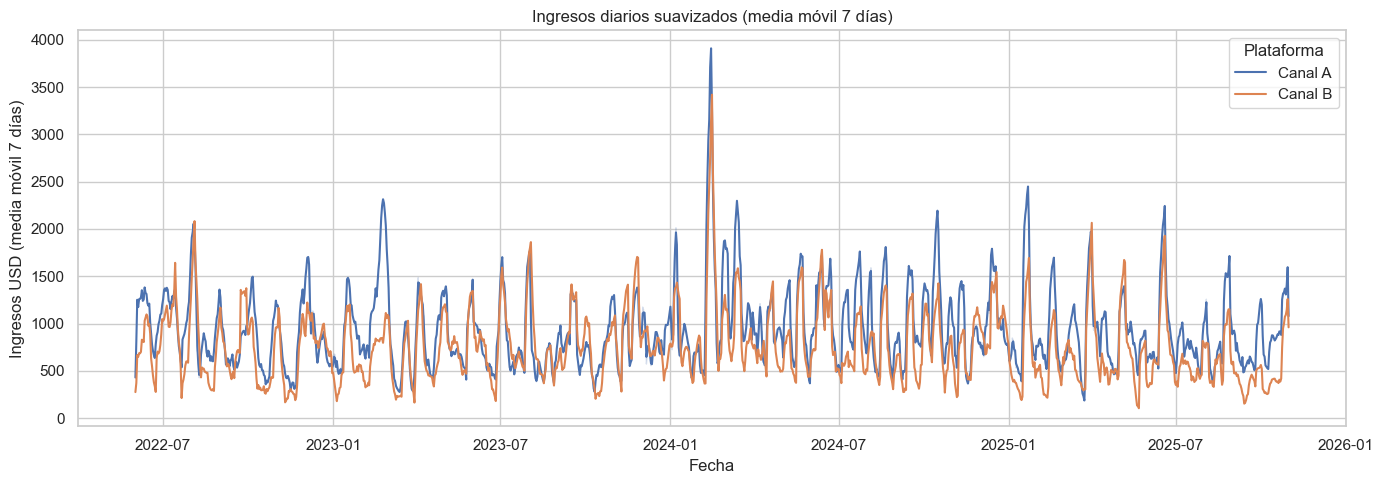

In [71]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=fact, x="Fecha", y="Ingresos_roll7", hue="Plataforma")
plt.title("Ingresos diarios suavizados (media móvil 7 días)")
plt.xlabel("Fecha")
plt.ylabel("Ingresos USD (media móvil 7 días)")
plt.tight_layout()
guardar_fig("ingresos_diarios_rolling7")
plt.show()


📁 Guardado: ..\EDA\plots\ingresos_mensuales.png


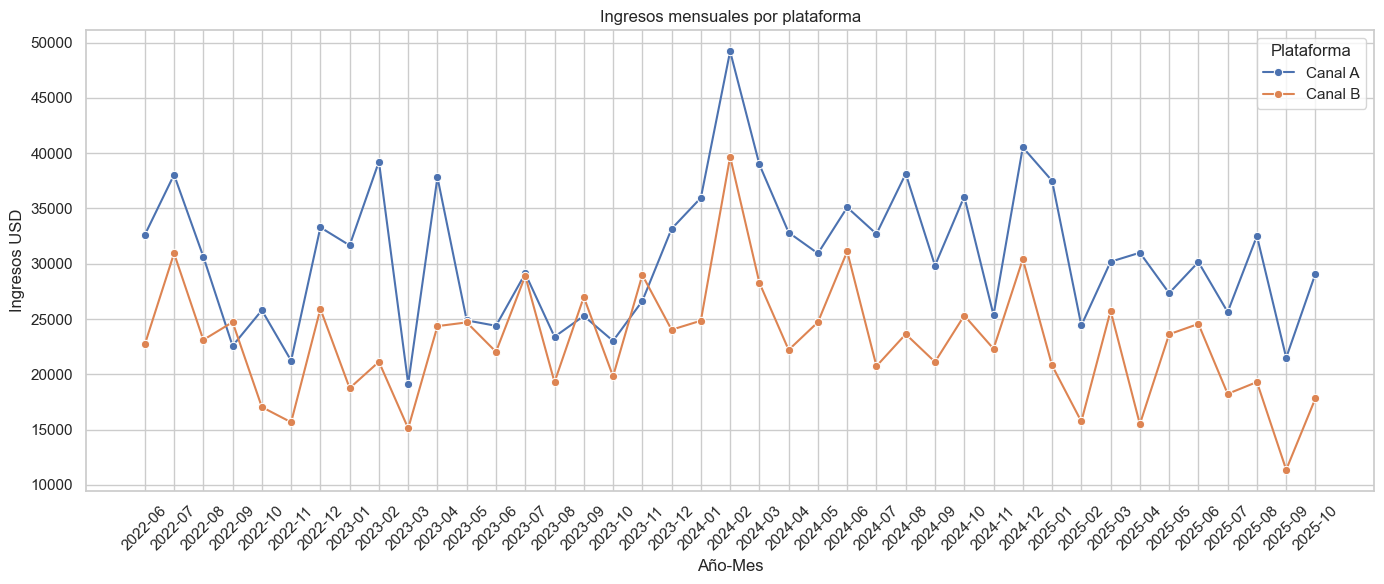

In [72]:
mensual = (
    fact.groupby(["Plataforma", "AñoMes"])["Ingresos_USD"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.lineplot(data=mensual, x="AñoMes", y="Ingresos_USD", hue="Plataforma", marker="o")
plt.xticks(rotation=45)
plt.title("Ingresos mensuales por plataforma")
plt.xlabel("Año-Mes")
plt.ylabel("Ingresos USD")
plt.tight_layout()
guardar_fig("ingresos_mensuales")
plt.show()


📁 Guardado: ..\EDA\plots\ingresos_diarios_comparados.png


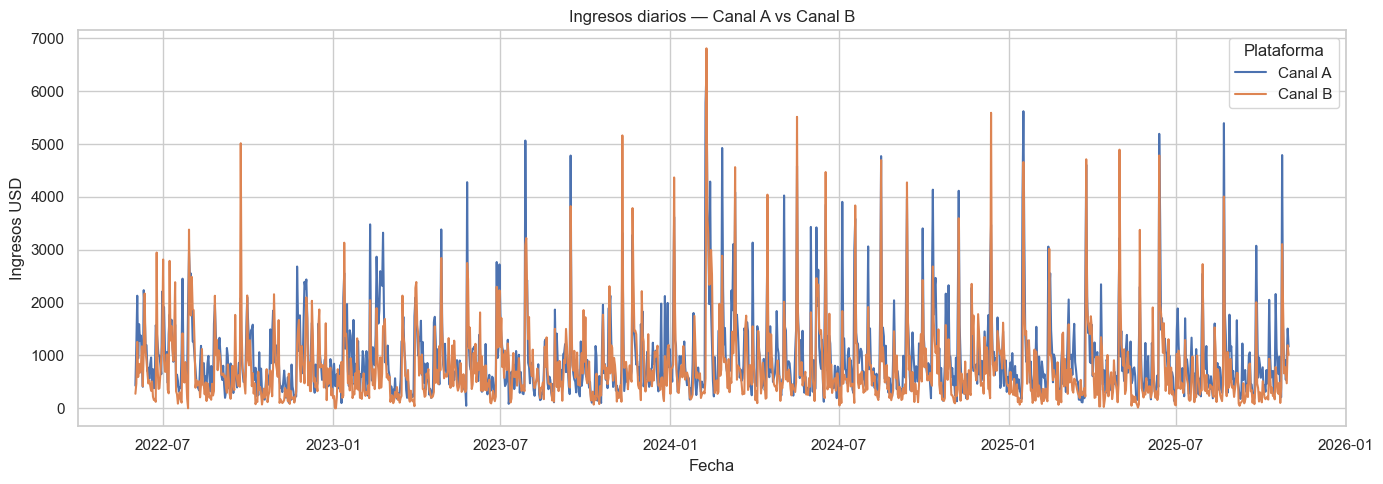

In [73]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=fact, x="Fecha", y="Ingresos_USD", hue="Plataforma")
plt.title("Ingresos diarios — Canal A vs Canal B")
plt.xlabel("Fecha")
plt.ylabel("Ingresos USD")
plt.tight_layout()
guardar_fig("ingresos_diarios_comparados")
plt.show()


📁 Guardado: ..\EDA\plots\ingresos_acumulados.png


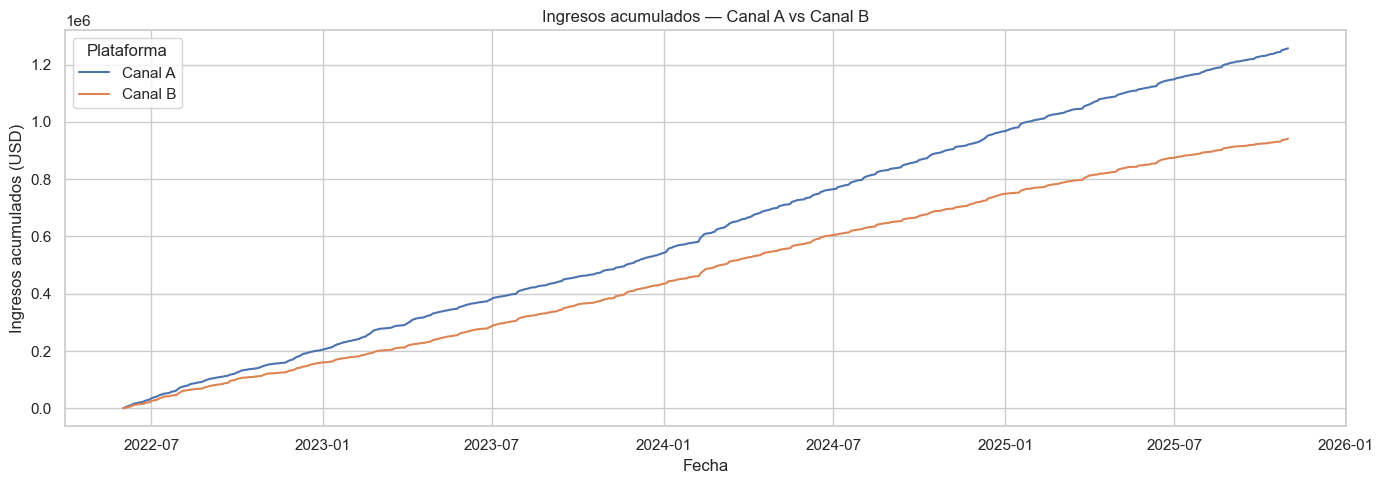

In [74]:
fact_sorted = fact.sort_values("Fecha").copy()
fact_sorted["Ingresos_acumulados"] = fact_sorted.groupby("Plataforma")["Ingresos_USD"].cumsum()

plt.figure(figsize=(14, 5))
sns.lineplot(data=fact_sorted, x="Fecha", y="Ingresos_acumulados", hue="Plataforma")
plt.title("Ingresos acumulados — Canal A vs Canal B")
plt.xlabel("Fecha")
plt.ylabel("Ingresos acumulados (USD)")
plt.tight_layout()
guardar_fig("ingresos_acumulados")
plt.show()


📁 Guardado: ..\EDA\plots\ingresos_trimestrales.png


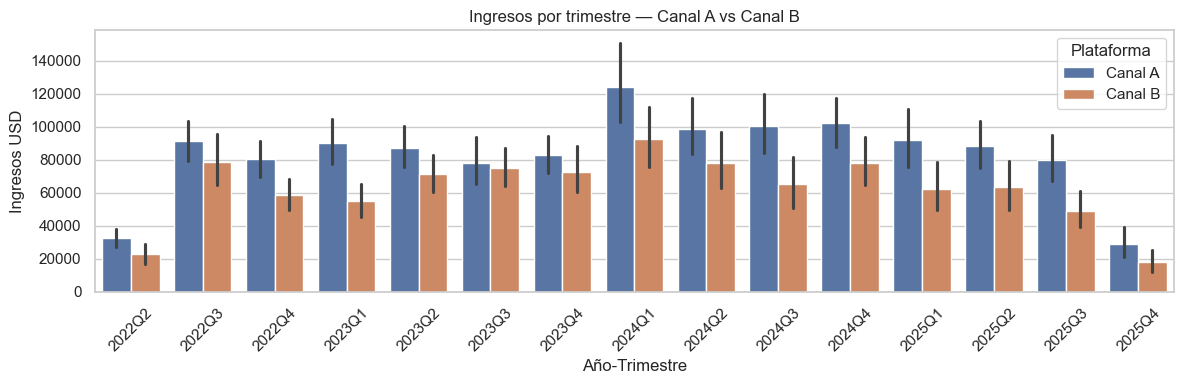

In [75]:
fact["AñoTrimestre"] = fact["Fecha"].dt.to_period("Q").astype(str)

plt.figure(figsize=(12, 4))
sns.barplot(
    data=fact,
    x="AñoTrimestre",
    y="Ingresos_USD",
    hue="Plataforma",
    estimator=sum,
)
plt.title("Ingresos por trimestre — Canal A vs Canal B")
plt.xticks(rotation=45)
plt.xlabel("Año-Trimestre")
plt.ylabel("Ingresos USD")
plt.tight_layout()
guardar_fig("ingresos_trimestrales")
plt.show()



 ## 6. Relación DAU → Ingresos

📁 Guardado: ..\EDA\plots\scatter_dau_ingresos.png


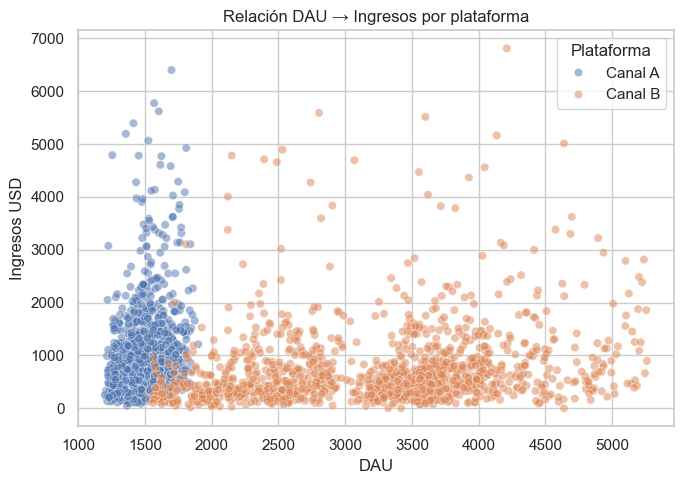

In [76]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=fact,
    x="DAU",
    y="Ingresos_USD",
    hue="Plataforma",
    alpha=0.5,
)
plt.title("Relación DAU → Ingresos por plataforma")
plt.xlabel("DAU")
plt.ylabel("Ingresos USD")
plt.tight_layout()
guardar_fig("scatter_dau_ingresos")
plt.show()



 ## 7. Correlaciones entre métricas clave

📁 Guardado: ..\EDA\plots\heatmap_correlaciones_core.png


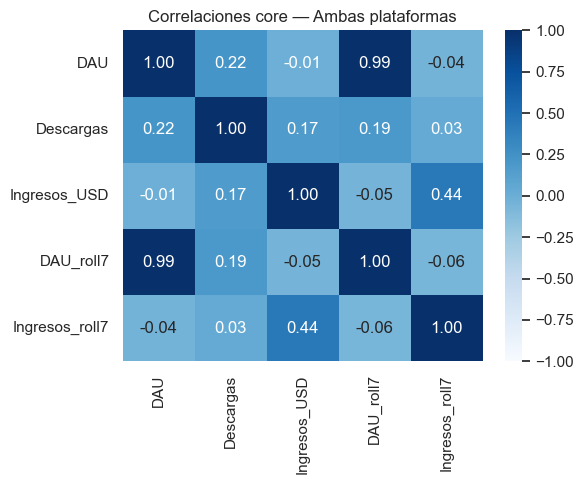

In [77]:
# === HEATMAP CORE (ambas plataformas, métricas comunes) ===
cols_core = ["DAU", "Descargas", "Ingresos_USD", "DAU_roll7", "Ingresos_roll7"]

corr_core = fact[cols_core].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_core,
    annot=True,
    cmap="Blues",
    vmin=-1,
    vmax=1,
    fmt=".2f",
)
plt.title("Correlaciones core — Ambas plataformas")
plt.tight_layout()
guardar_fig("heatmap_correlaciones_core")
plt.show()


📁 Guardado: ..\EDA\plots\heatmap_correlaciones_canalA.png


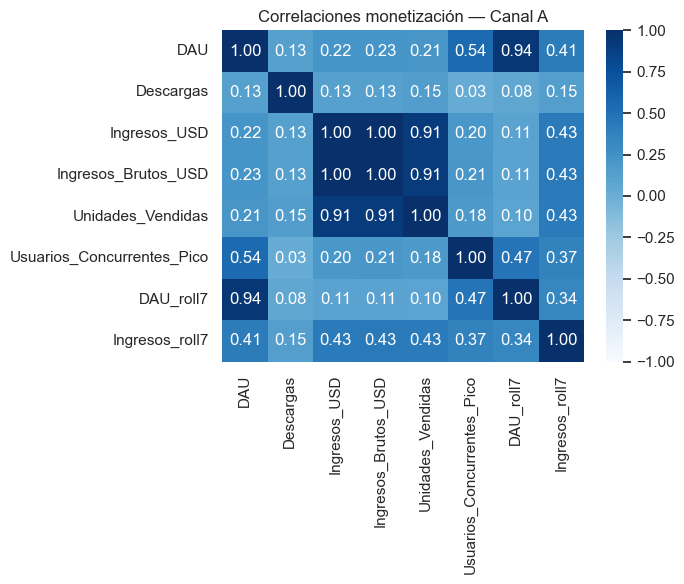

In [78]:
# === HEATMAP MONETIZACIÓN — CANAL A ===
canal_a = fact[fact["Plataforma"] == "Canal A"].copy()

cols_a = [
    "DAU",
    "Descargas",
    "Ingresos_USD",
    "Ingresos_Brutos_USD",
    "Unidades_Vendidas",
    "Usuarios_Concurrentes_Pico",
    "DAU_roll7",
    "Ingresos_roll7",
]

corr_a = canal_a[cols_a].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(
    corr_a,
    annot=True,
    cmap="Blues",
    vmin=-1,
    vmax=1,
    fmt=".2f",
)
plt.title("Correlaciones monetización — Canal A")
plt.tight_layout()
guardar_fig("heatmap_correlaciones_canalA")
plt.show()


📁 Guardado: ..\EDA\plots\heatmap_correlaciones_canalB.png


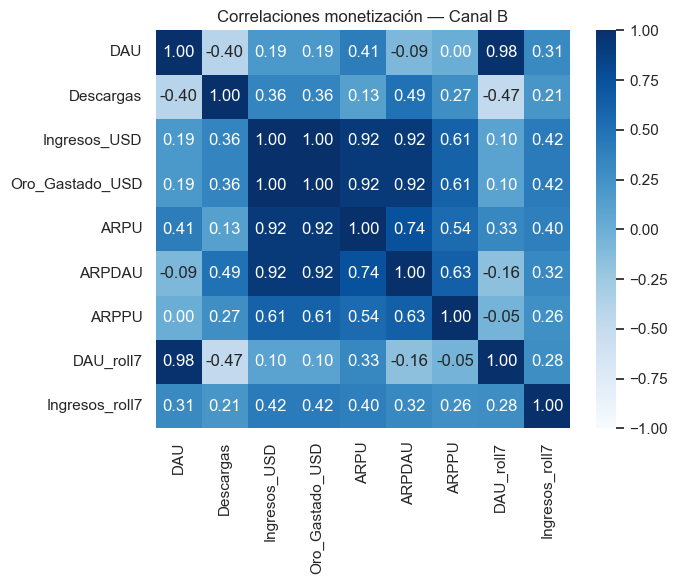

===== 🔵 CORRELACIONES CORE (ambas plataformas) =====
                  DAU  Descargas  Ingresos_USD  DAU_roll7  Ingresos_roll7
DAU             1.000      0.219        -0.009      0.994          -0.041
Descargas       0.219      1.000         0.167      0.190           0.033
Ingresos_USD   -0.009      0.167         1.000     -0.050           0.438
DAU_roll7       0.994      0.190        -0.050      1.000          -0.058
Ingresos_roll7 -0.041      0.033         0.438     -0.058           1.000


===== 🔵 CORRELACIONES CANAL A =====
                              DAU  Descargas  Ingresos_USD  \
DAU                         1.000      0.126         0.223   
Descargas                   0.126      1.000         0.128   
Ingresos_USD                0.223      0.128         1.000   
Ingresos_Brutos_USD         0.225      0.128         1.000   
Unidades_Vendidas           0.215      0.149         0.910   
Usuarios_Concurrentes_Pico  0.540      0.026         0.202   
DAU_roll7                   0.9

In [79]:
# === HEATMAP MONETIZACIÓN — CANAL B ===
canal_b = fact[fact["Plataforma"] == "Canal B"].copy()

cols_b = [
    "DAU",
    "Descargas",
    "Ingresos_USD",
    "Oro_Gastado_USD",
    "ARPU",
    "ARPDAU",
    "ARPPU",
    "DAU_roll7",
    "Ingresos_roll7",
]

# Nos aseguramos de que existen y que tienen datos suficientes
cols_b_validas = [c for c in cols_b if c in canal_b.columns]
df_b_num = canal_b[cols_b_validas].select_dtypes(include="number")

# Filtramos columnas casi vacías (por si acaso)
df_b_num = df_b_num.dropna(axis=1, thresh=30)

if df_b_num.shape[1] < 2:
    print("❌ No hay suficientes métricas con datos para hacer heatmap de Canal B.")
else:
    corr_b = df_b_num.corr()

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        corr_b,
        annot=True,
        cmap="Blues",
        vmin=-1,
        vmax=1,
        fmt=".2f",
    )
    plt.title("Correlaciones monetización — Canal B")
    plt.tight_layout()
    guardar_fig("heatmap_correlaciones_canalB")
    plt.show()

# Además imprimimos las matrices numéricas para usarlas en conclusiones
print("===== 🔵 CORRELACIONES CORE (ambas plataformas) =====")
try:
    print(fact[cols_core].corr().round(3))
except Exception as e:
    print("Error CORE:", e)

print("\n\n===== 🔵 CORRELACIONES CANAL A =====")
try:
    print(canal_a[cols_a].corr().round(3))
except Exception as e:
    print("Error A:", e)

print("\n\n===== 🔵 CORRELACIONES CANAL B =====")
try:
    print(df_b_num.corr().round(3))
except Exception as e:
    print("Error B:", e)



 ## 8. Distribución geográfica — Steam



 Usamos SteamInGameSales para ver unidades vendidas por país y región.

Columnas SteamInGameSales: Index(['Date', 'Product(ID#)', 'Game', 'Item(ID#)', 'Description', 'Category',
       'Country Code', 'Country', 'Region', 'Gross Units Sold',
       'Chargeback/Returns', 'Net Units Sold', ' Average Price', 'Currency',
       'Gross Steam Sales (USD)', 'Chargeback/Returns (USD)', 'VAT/Tax (USD)',
       'Net Steam Sales (USD)'],
      dtype='object')
📁 Guardado: ..\EDA\plots\steam_top_paises.png


C:\Users\cubea\AppData\Local\Temp\ipykernel_37236\1340159893.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


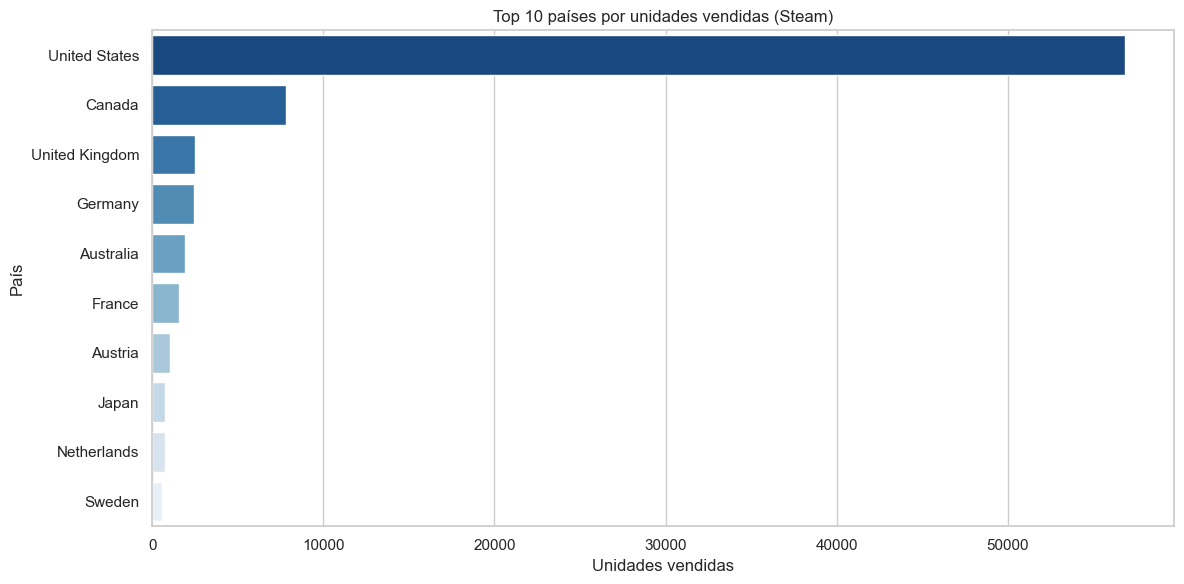

C:\Users\cubea\AppData\Local\Temp\ipykernel_37236\1340159893.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


📁 Guardado: ..\EDA\plots\steam_top_regiones.png


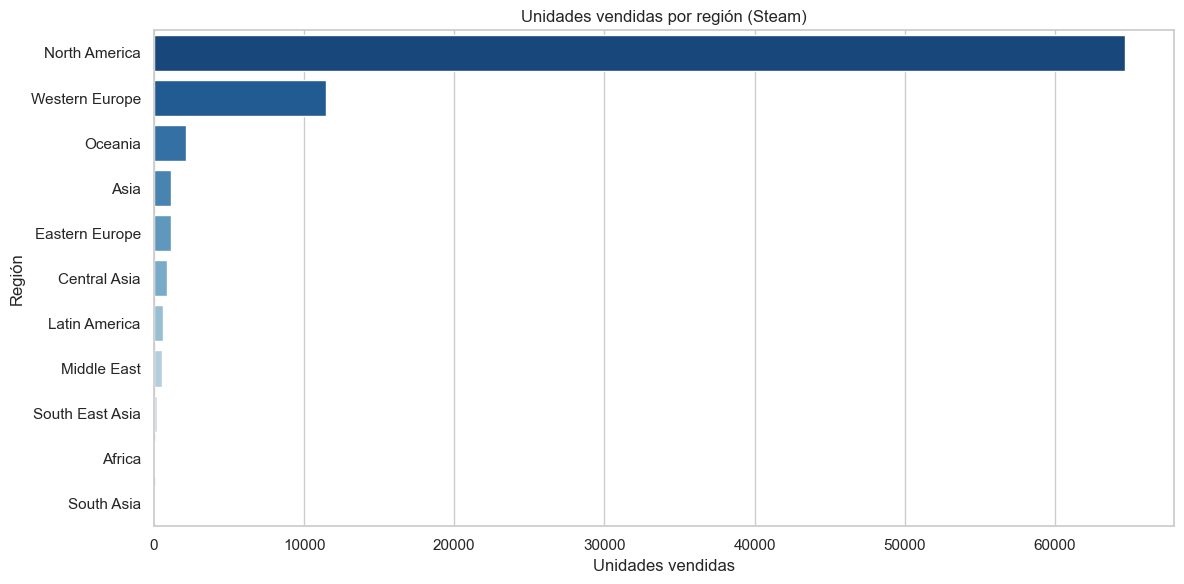

In [80]:
print("Columnas SteamInGameSales:", steam_sales.columns)

# Países (Country)
if "Country" in steam_sales.columns and "Gross Units Sold" in steam_sales.columns:
    top_paises = (
        steam_sales.groupby("Country")["Gross Units Sold"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=top_paises.values,
        y=top_paises.index,
        palette="Blues_r",
    )
    plt.title("Top 10 países por unidades vendidas (Steam)")
    plt.xlabel("Unidades vendidas")
    plt.ylabel("País")
    plt.tight_layout()
    guardar_fig("steam_top_paises")
    plt.show()
else:
    print("⚠ No se encontraron columnas Country / Gross Units Sold en SteamInGameSales.")

# Regiones (Region)
if "Region" in steam_sales.columns and "Gross Units Sold" in steam_sales.columns:
    regiones = (
        steam_sales.groupby("Region")["Gross Units Sold"]
        .sum()
        .sort_values(ascending=False)
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=regiones.values,
        y=regiones.index,
        palette="Blues_r",
    )
    plt.title("Unidades vendidas por región (Steam)")
    plt.xlabel("Unidades vendidas")
    plt.ylabel("Región")
    plt.tight_layout()
    guardar_fig("steam_top_regiones")
    plt.show()
else:
    print("⚠ No se encontraron columnas Region / Gross Units Sold en SteamInGameSales.")



 ## 9. Distribución del gasto in-game — PlayFab (whales)

📁 Guardado: ..\EDA\plots\playfab_revenue_hist.png


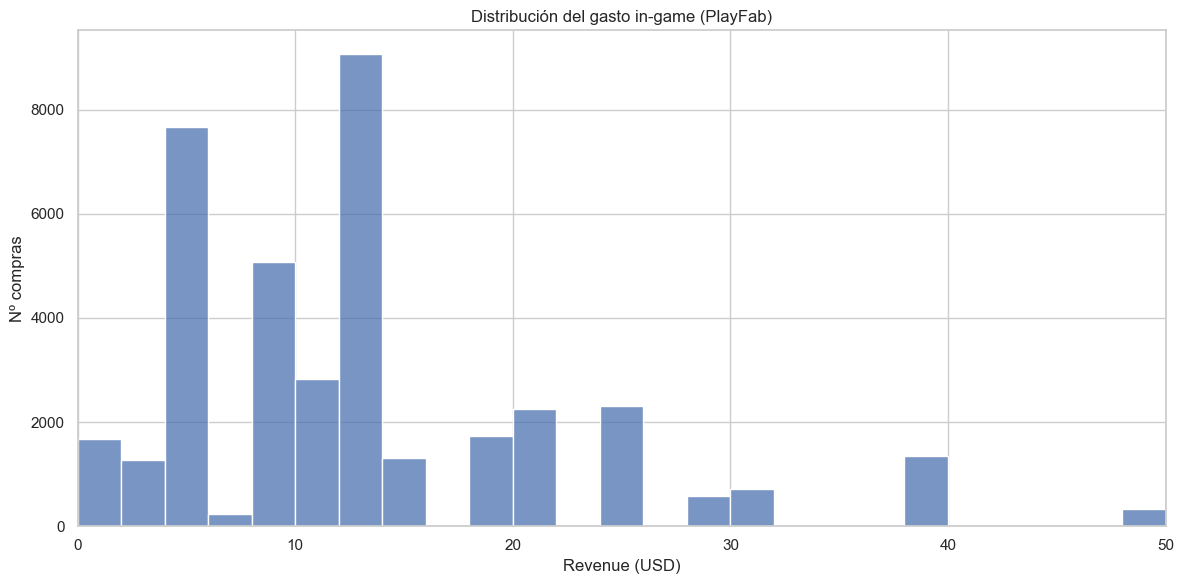


Estadísticas de gasto (PlayFab):
count    39127.00
mean        14.41
std         12.83
min          0.00
50%         13.50
75%         19.99
90%         25.00
95%         39.99
99%         50.00
max        100.00
Name: Revenue, dtype: float64

Usuarios 'whale' (>= P95 = 39.99):
- % de jugadores: 6.13%
- % del revenue total: 22.03%

Percentiles de gasto (PlayFab):
0.50    13.50
0.75    19.99
0.90    25.00
0.95    39.99
0.99    50.00
Name: Revenue, dtype: float64


In [81]:
if playfab is not None and "Revenue" in playfab.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(playfab["Revenue"], bins=50)
    plt.xlim(0, playfab["Revenue"].quantile(0.99))
    plt.title("Distribución del gasto in-game (PlayFab)")
    plt.xlabel("Revenue (USD)")
    plt.ylabel("Nº compras")
    plt.tight_layout()
    guardar_fig("playfab_revenue_hist")
    plt.show()

    desc = playfab["Revenue"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]).round(2)
    print("\nEstadísticas de gasto (PlayFab):")
    print(desc)

    p95 = desc["95%"]
    whales = playfab[playfab["Revenue"] >= p95]
    share_whales = len(whales) / len(playfab) * 100
    revenue_whales = whales["Revenue"].sum() / playfab["Revenue"].sum() * 100

    print(f"\nUsuarios 'whale' (>= P95 = {p95}):")
    print(f"- % de jugadores: {share_whales:.2f}%")
    print(f"- % del revenue total: {revenue_whales:.2f}%")

    # Percentiles extra (por si los quieres para la slide de whales)
    percentiles = playfab["Revenue"].quantile([0.5, 0.75, 0.9, 0.95, 0.99])
    print("\nPercentiles de gasto (PlayFab):")
    print(percentiles)
else:
    print("⚠ No se ha encontrado PlayFab con columna Revenue. Saltando análisis de gasto.")



 ## 10. Resumen rápido de FACT (para conclusiones posteriores)

In [82]:
df = fact.copy()

print("📌 COLUMNAS:")
print(df.columns.tolist())
print("\n")

print("📌 TIPOS DE DATOS:")
print(df.dtypes)
print("\n")

print("📌 NULOS POR COLUMNA:")
print(df.isna().sum())
print("\n")

print("📌 VALORES ÚNICOS POR COLUMNA:")
print(df.nunique())
print("\n")

print("📌 RANGOS NUMÉRICOS (describe):")
print(df.describe().T)
print("\n")

print("📌 RANGO DE FECHAS:")
print(df["Fecha"].min(), "→", df["Fecha"].max())
print("\n")

print("📌 5 PRIMERAS FILAS:")
display(df.head())

print("📌 5 ÚLTIMAS FILAS:")
display(df.tail())


📌 COLUMNAS:
['Fecha', 'Año', 'Trimestre', 'Mes', 'Mes_Nombre', 'DiaSemana', 'DiaSemana_Nombre', 'Plataforma', 'Juego', 'DAU', 'Descargas', 'Ingresos_USD', 'Ingresos_Brutos_USD', 'Unidades_Vendidas', 'Usuarios_Concurrentes_Pico', 'Oro_Gastado_USD', 'ARPDAU', 'ARPU', 'ARPPU', 'DAU_roll7', 'Ingresos_roll7', 'AñoMes', 'AñoTrimestre']


📌 TIPOS DE DATOS:
Fecha                         datetime64[ns]
Año                                    int64
Trimestre                             object
Mes                                    int64
Mes_Nombre                            object
DiaSemana                              int64
DiaSemana_Nombre                      object
Plataforma                            object
Juego                                 object
DAU                                    int64
Descargas                            float64
Ingresos_USD                         float64
Ingresos_Brutos_USD                  float64
Unidades_Vendidas                    float64
Usuarios_Concurren

,Fecha,Año,Trimestre,Mes,Mes_Nombre,DiaSemana,DiaSemana_Nombre,Plataforma,Juego,DAU,Descargas,Ingresos_USD,Ingresos_Brutos_USD,Unidades_Vendidas,Usuarios_Concurrentes_Pico,Oro_Gastado_USD,ARPDAU,ARPU,ARPPU,DAU_roll7,Ingresos_roll7,AñoMes,AñoTrimestre
0,2022-06-01,2022,2022Q2,6,junio,2,miércoles,Canal A,Proyecto Aurora,1294,0.0,428.44,449.68,44.0,83.0,NaN,NaN,NaN,NaN,1294.000000,428.44,2022-06,2022Q2
1,2022-06-01,2022,2022Q2,6,junio,2,miércoles,Canal B,Proyecto Aurora,5020,42.0,274.37,NaN,NaN,NaN,274.37,5.47,0.13,3048.56,5020.000000,274.37,2022-06,2022Q2
2,2022-06-02,2022,2022Q2,6,junio,3,jueves,Canal A,Proyecto Aurora,1315,0.0,1195.96,1294.24,67.0,80.0,NaN,NaN,NaN,NaN,1304.500000,812.20,2022-06,2022Q2
3,2022-06-02,2022,2022Q2,6,junio,3,jueves,Canal B,Proyecto Aurora,5147,52.0,467.31,NaN,NaN,NaN,467.31,9.08,0.22,2225.29,5083.500000,370.84,2022-06,2022Q2
4,2022-06-03,2022,2022Q2,6,junio,4,viernes,Canal A,Proyecto Aurora,1355,0.0,2129.47,2304.43,117.0,87.0,NaN,NaN,NaN,NaN,1321.333333,1251.29,2022-06,2022Q2


📌 5 ÚLTIMAS FILAS:


,Fecha,Año,Trimestre,Mes,Mes_Nombre,DiaSemana,DiaSemana_Nombre,Plataforma,Juego,DAU,Descargas,Ingresos_USD,Ingresos_Brutos_USD,Unidades_Vendidas,Usuarios_Concurrentes_Pico,Oro_Gastado_USD,ARPDAU,ARPU,ARPPU,DAU_roll7,Ingresos_roll7,AñoMes,AñoTrimestre
2591,2025-10-29,2025,2025Q4,10,octubre,2,miércoles,Canal B,Proyecto Aurora,1820,170.0,472.38,NaN,NaN,NaN,472.38,25.95,0.08,2624.33,1908.714286,1144.558571,2025-10,2025Q4
2592,2025-10-30,2025,2025Q4,10,octubre,3,jueves,Canal A,Proyecto Aurora,1271,23.0,1507.37,1608.93,75.0,126.0,NaN,NaN,NaN,NaN,1273.714286,1595.877143,2025-10,2025Q4
2593,2025-10-30,2025,2025Q4,10,octubre,3,jueves,Canal B,Proyecto Aurora,1863,209.0,1192.74,NaN,NaN,NaN,1192.74,64.02,0.21,3313.17,1949.285714,1259.164286,2025-10,2025Q4
2594,2025-10-31,2025,2025Q4,10,octubre,4,viernes,Canal A,Proyecto Aurora,1267,39.0,1165.40,1287.90,58.0,117.0,NaN,NaN,NaN,NaN,1275.428571,1077.907143,2025-10,2025Q4
2595,2025-10-31,2025,2025Q4,10,octubre,4,viernes,Canal B,Proyecto Aurora,1807,367.0,1009.34,NaN,NaN,NaN,1009.34,55.86,0.18,5046.70,1949.285714,959.677143,2025-10,2025Q4
